In [1]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [56]:
import numpy as np
import matplotlib.pyplot as plt

from json import loads,dumps
import cv2
import base64

%matplotlib inline

In [3]:
(X,Y),(x,y) = tf.keras.datasets.mnist.load_data()

X = X.reshape(-1,784,1).astype(np.float32) / 255
x = x.reshape(-1,784,1).astype(np.float32) / 255

Y = tf.keras.utils.to_categorical(Y)
y = tf.keras.utils.to_categorical(y)

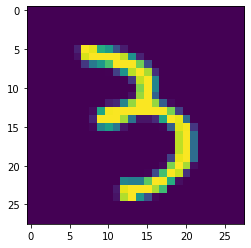

In [4]:
i = 40502
plt.imshow(X[i:i+1].reshape(28,28))

In [376]:
??LSTM

In [414]:
inp = Input(shape=(784,1),name="input")

l1 = LSTM(2,return_sequences=True,name="l1")(inp)
l2 = LSTM(4,name="l2")(l1)

out = Dense(10,activation="softmax",name="out")(l2)
model = Model([inp],[out])

In [415]:
l1 = model.get_layer("l1")
l2 = model.get_layer("l2")

In [417]:
model.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784, 1)]          0         
_________________________________________________________________
l1 (LSTM)                    (None, 784, 2)            32        
_________________________________________________________________
l2 (LSTM)                    (None, 4)                 112       
_________________________________________________________________
out (Dense)                  (None, 10)                50        
Total params: 194
Trainable params: 194
Non-trainable params: 0
_________________________________________________________________


In [418]:
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'])

In [419]:
# model.fit(X,Y,batch_size=32,epochs=1,validation_data=(x,y))

In [420]:
def set_levels(network:dict,inputNodes:list,currentLevel:int=0):
    for node in inputNodes:
        network[node]['level'] = currentLevel
        set_levels(network,network[node]['outbound'],currentLevel+1)

def get_network_conf(model,input_nodes:list):
    model_conf = loads(model.to_json())
    network = {
        l['name']:{
            "inbound":[],
            "outbound":[],
            "class_name":l['class_name']
        } for l in model_conf['config']['layers']
    }
    
    for l in model_conf['config']['layers']:
        if len(l['inbound_nodes']):
            for n in l['inbound_nodes'][0]:
                network[l['name']]['inbound'].append(n[0])
                network[n[0]]['outbound'].append(l['name'])

    set_levels(network,input_nodes,0)
    levels = [[] for i in range(max([i['level'] for _,i in network.items()])+1)]
    for node,val in network.items():
        levels[val['level']].append(node)
    return network,levels

In [421]:
def image2base64(image:np.ndarray,norm:bool=True)->str:
    image = ( image * ( 255 if norm else 1 ) ).astype(np.uint8)
    image = cv2.resize(image,(128,128))
    retval, buffer = cv2.imencode('.png', image)
    buffer = base64.b64encode(buffer)
    return 'data:image/png;base64,' + str(buffer,encoding="utf-8")

def prep_conv2d(value:np.ndarray,*args,**kwargs)->list:
    _,h,w,c = output.shape
    images = output.reshape(c,h,w)
    return [ image2base64(image) for image in images ]

def prep_dense(value:np.ndarray,*args,**kwargs)->list:
    return ((value.astype(float) / value.max())[0]).tolist()
    
def prepare_input_image(image:np.ndarray,input_config):
    image = image.reshape(input_config['shape'])
    return image2base64(image)

def prep_input_layer(value,layer:tf.keras.layers.Layer,input_config:dict,*args,**kwargs):
    return input_config['transformer'](value,input_config)
    
def prep_lstm(value:np.ndarray,layer:tf.keras.layers.Layer,*args,**kwargs):
    if layer.return_sequences:
        value,*_ = value
        _min = value.min(axis=1).reshape(-1,1)
        _max = value.max(axis=1).reshape(-1,1)
        value = ((value - _min)/(_max - _min))
        value[np.isnan(value)] = 0
        return value.astype(float).tolist()
        
    return ((value / value.max())[0]).tolist()
    
prep_functions = {
    "Conv2D":prep_conv2d,
    "Dense":prep_dense,
    "InputLayer":prep_input_layer,
    "MaxPooling2D":prep_conv2d,
    "Flatten":prep_dense,
    "LSTM":prep_lstm
}

In [422]:
def set_output(model,network:dict,levels:list,input_values:dict,input_config:dict):
    temp_out = dict()
    for level in levels:
        for layer in level:
            layer_ = network[layer]
            _layer = model.get_layer(layer)
            if len(layer_['inbound']):
                if len(layer_['inbound']) < 2:
                    inputs,*_ = [temp_out[i] for i in layer_['inbound']]
                    out = _layer(inputs)
                    temp_out[layer] = out
                    network[layer]['outputs'] = prep_functions[layer_['class_name']](
                        value=out.numpy(),
                        layer=_layer,
                        input_config=input_config
                    )
                else:
                    inputs = [temp_out[i] for i in layer_['inbound']]
                    out = _layer(inputs)
                    temp_out[layer] = out
                    network[layer]['outputs'] = prep_functions[layer_['class_name']](
                        value=out.numpy(),
                        layer=_layer,
                        input_config=input_config
                    )
            else:
                inputs = input_values[layer]
                out = _layer(inputs['value'])
                temp_out[layer] = out
                network[layer]['outputs'] = prep_functions[layer_['class_name']](
                    value=out.numpy(),
                    layer = _layer,
                    input_config = input_config[layer]
                )

In [423]:
input_config = {
    "examples":[
        {
            "input":{ 
                "value":x[0:1]
            },
            "some_other_input_layer":{
                
            }
        }
    ],
    "input_layers_config":{
        "input":{
            "type":"image",
            "shape":(28,28),
            "transformer":prepare_input_image,
            "resize":(128,128)
        }
    },
    "input_nodes":['input']
}

In [424]:
network,levels = get_network_conf(model,input_config['input_nodes'])

In [425]:
set_output(model,network,levels,input_config['examples'][0],input_config['input_layers_config'])

<ipython-input-421-d36a026d2973>:28: RuntimeWarning: invalid value encountered in true_divide
  value = ((value - _min)/(_max - _min))


In [427]:
network['l1']

{'inbound': ['input'],
 'outbound': ['l2'],
 'class_name': 'LSTM',
 'level': 1,
 'outputs': [[0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],
  [0.0, 0.0],

In [18]:
model.save_weights("./saved_model/mnist_dense")
open("./saved_model/mnist_dense.json","w+").write(model.to_json())

2305